# 2 - Modelo de persistencia

## 2.1 Descripción

El primero modelo que se utilizará será el modelo de persistencia. Este simplmente proyecta el último valor de hacia el futuro. Está definido como:

$$y_t = y_{t-1} + \epsilon_t$$

y por lo tanto, la predicción se define como:

$$\hat{y}_t = y_{t-1}$$

## 2.2 Generación de conjunto de datos
Cargamos las librerías y los datos

In [1]:
# Importamos las librerias necesarias para trabajar
from statsmodels.regression.linear_model import yule_walker
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from numpy.fft import fft, fftfreq, fftshift
from datetime import time
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mysql.connector
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import copy
import sklearn

# Seteamos el estilo de los graficos
sns.set(style="whitegrid")

# Configuramos los graficos con latex
plt.rc('text', usetex=True)

In [2]:
# Abrimos la base de datos
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='datos_ordenados'
)

# Extraemos la informacion en un dataframe
df = pd.read_sql("SELECT * FROM cgm_ordenados", mydb)   # Cargamos todos los datos 
#df.drop('id', axis=1, inplace=True)                   # Eliminamos el indice
df.set_index('datetime', inplace=True)                # Definimos datetime como indice
df.sort_index(inplace=True)                           # Ordenamos en base a datetime
df.index.freq = pd.infer_freq(df.index)
# Mostramos los resultados
print('Tamano de la tabla: {} filas y {} columnas'.format(df.shape[0], df.shape[1]))
print('Tiempo del estudio:')
print(' - Inicio  : {}'.format(str(df.index[0])))
print(' - Final   : {}'.format(str(df.index[-1])))
print(' - Duración: {}'.format(str(df.index[-1] - df.index[0])))
df.head(3)

Tamano de la tabla: 1728 filas y 6 columnas
Tiempo del estudio:
 - Inicio  : 2020-01-24 17:00:00
 - Final   : 2020-01-30 16:55:00
 - Duración: 5 days 23:55:00


,sensor_glucose,sensor_calibration_bg,meal,basal_insulin,bolus_insulin,exercise
datetime,,,,,,
2020-01-24 17:00:00,NaN,125.0,NaN,NaN,NaN,NaN
2020-01-24 17:05:00,126.0,NaN,NaN,NaN,NaN,NaN
2020-01-24 17:10:00,128.0,NaN,NaN,NaN,NaN,NaN


Extraemos y procesamos las variables utilizadas para el modelo

In [3]:
# en este caso, solo es la variable de la glucosa
y = copy.copy(df['sensor_glucose'])
# Realizamos una interpolacion para eliminar los NaN
y.interpolate(inplace=True, limit_direction='both')
# Cambiamos el nombre de la variable a y (por simplicidad a futuro)
y.rename('y', inplace=True)
# Por comodidad, se trabajara con los datos como Dataframe y no como Serie
y = pd.DataFrame(y)
y.head(5)

,y
datetime,
2020-01-24 17:00:00,126.0
2020-01-24 17:05:00,126.0
2020-01-24 17:10:00,128.0
2020-01-24 17:15:00,146.0
2020-01-24 17:20:00,158.0


Dividimos los datos en el conjunto de entrenamiento y de testeo

In [4]:
# Parametros
fecha_limite = '2020-01-28 16:59:59'
y_train = copy.copy(y[:fecha_limite])
y_test = copy.copy(y[fecha_limite:])
print('- porcentaje de training: {:2.2f}%'.format(100*len(y_train)/len(y)))
print('- porcentaje de testing : {:2.2f}%'.format(100*len(y_test)/len(y)))

- porcentaje de training: 66.67%
- porcentaje de testing : 33.33%


## 2.3 Generación del modelo

En este caso, el modelo se define como una función sencilla

In [5]:
# Modelo de persistencia
def persistence_model(x):
    '''
    Se considera que la entrada x es un vector fila, por lo que simplemente se devuelve
    el ultimo valor del vector
    '''
    x = x[-1]
    return x

## 2.4 Predicción con el modelo y cálculo del error

In [6]:
# Predicion de 6 pasos
k = 6
# Realizamos la prediccion
for i in range(k):
    y_train['y+{}'.format(i+1)] = y_train.apply(persistence_model, axis=1)
    y_test['y+{}'.format(i+1)] = y_test.apply(persistence_model, axis=1)

# Se debe desfasar la prediccion para que coincida con el valor el tiempo
for i in range(k):
    y_train['y+{}'.format(i+1)] = y_train['y+{}'.format(i+1)].shift(i+1)
    y_test['y+{}'.format(i+1)] = y_test['y+{}'.format(i+1)].shift(i+1)

Exraemos los errores para 5 minutos, para 30 minutos y para la trayectoria

In [7]:
# Funcion para la metrica de la trayectoria
def error_trayectoria(vector):
    '''
    Se calcula una norma de error como la diferencia entre la prediccion y la medicion
    real para un tiempo t. Se utilizara la norma euclidiana
    '''
    y_predict = vector['y+1':'y+6']
    y_real = vector['y']
    error = (y_predict - y_real) ** 2
    error = sum(error) / len(error)
    return np.sqrt(error)

In [8]:
# 1 paso adelante (5 minutos)
y_train['e_1_paso'] = y_train['y+1'] - y_train['y']
y_test['e_1_paso'] = y_test['y+1'] - y_test['y']

# 6 pasos adelante (30 minutos)
y_train['e_6_paso'] = y_train['y+6'] - y_train['y']
y_test['e_6_paso'] = y_test['y+6'] - y_test['y']

# Trayectoria (5 a 30 minutos)
y_train['e_trajec'] = y_train.apply(error_trayectoria, axis=1) 
y_test['e_trajec'] = y_test.apply(error_trayectoria, axis=1)

## Análisis estadístico del error

In [9]:
y_train[['e_1_paso', 'e_6_paso', 'e_trajec']].describe()

,e_1_paso,e_6_paso,e_trajec
count,1151.000000,1146.000000,1146.000000
mean,-0.091225,-0.544503,17.447190
std,6.948170,34.889853,15.788718
min,-45.000000,-118.000000,0.707107
25%,-4.000000,-19.000000,5.400617
50%,0.000000,-1.000000,11.954771
75%,3.000000,15.000000,24.981656
max,29.000000,124.000000,84.311921


In [10]:
y_test[['e_1_paso', 'e_6_paso', 'e_trajec']].describe()

,e_1_paso,e_6_paso,e_trajec
count,575.000000,570.000000,570.000000
mean,0.071304,0.733333,17.382877
std,6.982566,33.187052,14.554684
min,-24.000000,-121.000000,0.408248
25%,-4.000000,-19.000000,6.435568
50%,0.000000,-2.000000,13.168758
75%,3.000000,18.000000,25.274303
max,27.000000,115.000000,77.913413


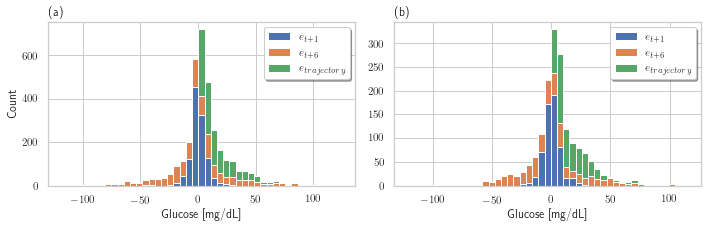

In [11]:
# Creamos la figura
fig, (ax1, ax2) = plt.subplots(1, 2)

#Parametros del grafico
data1 = [y_train['e_1_paso'].dropna(), y_train['e_6_paso'].dropna(), y_train['e_trajec'].dropna()]
data2 = [y_test['e_1_paso'].dropna(), y_test['e_6_paso'].dropna(), y_test['e_trajec'].dropna()]
colors = ['C0', 'C1', 'C2']
n_bins = 45
labels = ['$e_{t+1}$', '$e_{t+6}$', '$e_{trajectory}$']

# Realizamos el histograma
ax1.hist(data1, color=colors, bins=n_bins, label=labels, stacked=True)
ax2.hist(data2, color=colors, bins=n_bins, label=labels, stacked=True)

# Configuraciones
ax1.grid(True)
ax2.grid(True)
ax1.set_ylabel('Count')
ax1.set_xlabel('Glucose [mg/dL]')
ax2.set_xlabel('Glucose [mg/dL]')
ax1.legend(fancybox=True, shadow=True)
ax2.legend(fancybox=True, shadow=True)
ax1.set_title('(a)', loc='left')
ax2.set_title('(b)', loc='left')


x_size = 10
y_size = x_size / 3
fig.set_size_inches(x_size, y_size)
plt.tight_layout()
format_name = 'figs/error_histograma'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

## 1.5 Cálculo de indicadores de desempeño

In [12]:
resultados = pd.DataFrame(columns=['1 paso','6 paso','trajec'])

* Cálculo del error cuadrático medio RMSE

In [28]:
# Extraemos los vectores de los errores
e1 = copy.copy(y_train['e_1_paso'])
e6 = copy.copy(y_train['e_6_paso'])
ee = copy.copy(y_train['e_trajec'])
# Eliminamos los puntos los nan
e1.dropna(inplace=True)
e6.dropna(inplace=True)
ee.dropna(inplace=True)
# Calculamos el resultado
RMSE_1_paso = np.sqrt(sum(e1 ** 2) / len(e1))
RMSE_6_paso = np.sqrt(sum(e6 ** 2) / len(e6))
RMSE_trajec = np.sqrt(sum(ee ** 2) / len(ee))
# Agregamos el resultado a un dataframe
resultados.loc['RMSE', '1 paso'] = RMSE_1_paso
resultados.loc['RMSE', '6 paso'] = RMSE_6_paso
resultados.loc['RMSE', 'trajec'] = RMSE_trajec
# Lo desplegamos por consola
print(' - Training')
print('RMSE 1 paso : {:.3f}'.format(RMSE_1_paso))
print('RMSE 6 pasos: {:.3f}'.format(RMSE_6_paso))
print('RMSE traject: {:.3f}'.format(RMSE_trajec))

 - Training
RMSE 1 paso : 6.946
RMSE 6 pasos: 34.879
RMSE traject: 23.526


In [29]:
# Extraemos los vectores de los errores
e1 = copy.copy(y_test['e_1_paso'])
e6 = copy.copy(y_test['e_6_paso'])
ee = copy.copy(y_test['e_trajec'])
# Eliminamos los puntos los nan
e1.dropna(inplace=True)
e6.dropna(inplace=True)
ee.dropna(inplace=True)
# Calculamos el resultado
RMSE_1_paso = np.sqrt(sum(e1 ** 2) / len(e1))
RMSE_6_paso = np.sqrt(sum(e6 ** 2) / len(e6))
RMSE_trajec = np.sqrt(sum(ee ** 2) / len(ee))
# Agregamos el resultado a un dataframe
resultados.loc['RMSE', '1 paso'] = RMSE_1_paso
resultados.loc['RMSE', '6 paso'] = RMSE_6_paso
resultados.loc['RMSE', 'trajec'] = RMSE_trajec
# Lo desplegamos por consola
print(' - Testing')
print('RMSE 1 paso : {:.3f}'.format(RMSE_1_paso))
print('RMSE 6 pasos: {:.3f}'.format(RMSE_6_paso))
print('RMSE traject: {:.3f}'.format(RMSE_trajec))

 - Testing
RMSE 1 paso : 6.977
RMSE 6 pasos: 33.166
RMSE traject: 22.663


# Falta agregar la TG y ESOD-n

## 2.6 Gráficos

### Gráfico de glicemia predecida versus glicemia en tiempo real

* Realizamos una gráfico en el tiempo de un día de predicción para el conjunto de testing para todos los datos predichos

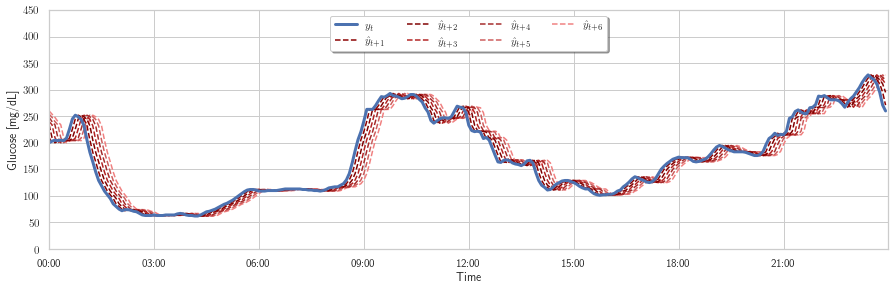

In [14]:
# Parametros
f_ini = pd.Timestamp('2020-01-29 00:00:00')
f_fin = pd.Timestamp('2020-01-29 23:59:59')

# Graficamos
fig, ax = plt.subplots()

ax.plot(y_test['y+6'][f_ini: f_fin], color='lightcoral', 
        linestyle='--', label='$\hat{y}_{t + 6}$')
ax.plot(y_test['y+5'][f_ini: f_fin], color='indianred', 
        linestyle='--', label='$\hat{y}_{t + 5}$')
ax.plot(y_test['y+4'][f_ini: f_fin], color='brown', 
        linestyle='--', label='$\hat{y}_{t + 4}$')
ax.plot(y_test['y+3'][f_ini: f_fin], color='firebrick', 
        linestyle='--', label='$\hat{y}_{t + 3}$')
ax.plot(y_test['y+2'][f_ini: f_fin], color='maroon', 
        linestyle='--', label='$\hat{y}_{t + 2}$')
ax.plot(y_test['y+1'][f_ini: f_fin], color='darkred', 
        linestyle='--', label='$\hat{y}_{t + 1}$')
ax.plot(y_test['y'][f_ini: f_fin], color='C0', linewidth=3.0
       , label='$y_{t}$')

# Parametros
ax.grid(True)
ax.set_ylim([0, 450])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucose [mg/dL]')
ax.set_xlabel('Time')

# leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc= 'upper center', ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/grafico_tiempo_1'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

* Realizamos un gráfico para la predicción sólo para 6 pasos adelante (30 minutos) 

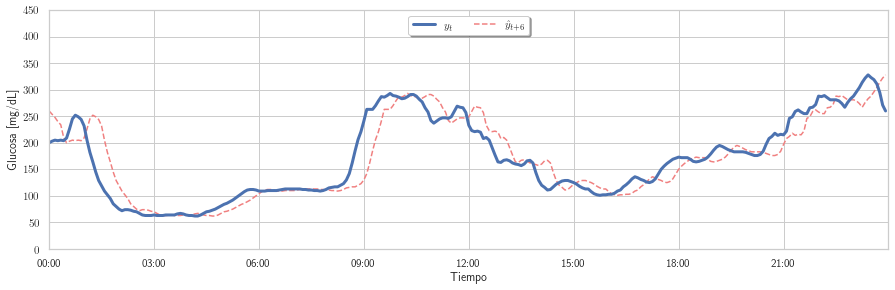

In [15]:
# Parametros
f_ini = pd.Timestamp('2020-01-29 00:00:00')
f_fin = pd.Timestamp('2020-01-29 23:59:59')

# Graficamos
fig, ax = plt.subplots()

ax.plot(y_test['y+6'][f_ini: f_fin], color='lightcoral', 
        linestyle='--', label='$\hat{y}_{t + 6}$')
ax.plot(y_test['y'][f_ini: f_fin], color='C0', linewidth=3.0
       , label='$y_{t}$')

# Parametros
ax.grid(True)
ax.set_ylim([0, 450])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucosa [mg/dL]')
ax.set_xlabel('Tiempo')

# leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc= 'upper center', ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/grafico_tiempo_2'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

### Gráfico del error

* Gráficamos el error del training

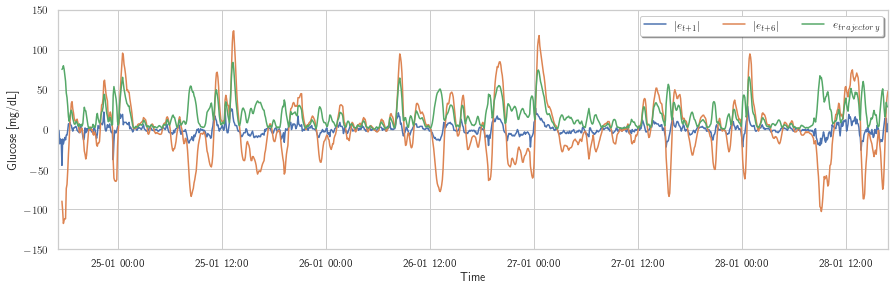

In [16]:
# Parametros
f_ini = y_train.index[0]
f_fin = y_train.index[-1]

# Graficamos
fig, ax = plt.subplots()

ax.plot(y_train['e_1_paso'][f_ini: f_fin], color='C0', linestyle='-', label='$|e_{t + 1}|$')
ax.plot(y_train['e_6_paso'][f_ini: f_fin], color='C1', linestyle='-', label='$|e_{t + 6}|$')
ax.plot(y_train['e_trajec'][f_ini: f_fin], color='C2', linestyle='-', label='$e_{trajectory}$')

# Parametros
ax.grid(True)
ax.set_ylim([-150, 150])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucose [mg/dL]')
ax.set_xlabel('Time')

# leyenda
ax.legend(ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/error_grafico_training'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

* Graficamos el error del testing

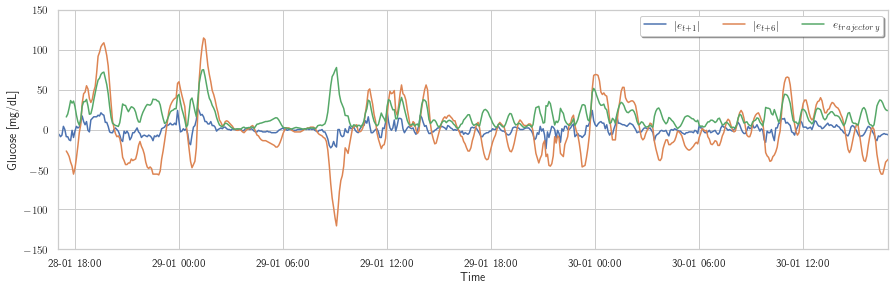

In [27]:
# Parametros
f_ini = y_test.index[0]
f_fin = y_test.index[-1]

# Graficamos
fig, ax = plt.subplots()

ax.plot(y_test['e_1_paso'][f_ini: f_fin], color='C0', linestyle='-', label='$|e_{t + 1}|$')
ax.plot(y_test['e_6_paso'][f_ini: f_fin], color='C1', linestyle='-', label='$|e_{t + 6}|$')
ax.plot(y_test['e_trajec'][f_ini: f_fin], color='C2', linestyle='-', label='$e_{trajectory}$')

# Parametros
ax.grid(True)
ax.set_ylim([-150, 150])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucose [mg/dL]')
ax.set_xlabel('Time')

# leyenda
ax.legend(ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/error_grafico_testing'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

### Análisis en frecuencia del error

* Periodograma para el training

In [18]:
e1 = y_train['e_1_paso'].dropna()
N = len(e1)
freq = fftfreq(N, 5*60)
E1 = fft(e1, norm='ortho')
E1_N = abs(E1) ** 2
E1_N = pd.Series(E1_N, index=freq)
E1_N = E1_N[freq > 0]

e6 = y_train['e_6_paso'].dropna()
N = len(e6)
freq = fftfreq(N, 5*60)
E6 = fft(e6, norm='ortho')
E6_N = abs(E6) ** 2
E6_N = pd.Series(E6_N, index=freq)
E6_N = E6_N[freq > 0]

ee = y_train['e_trajec'].dropna()
N = len(ee)
freq = fftfreq(N, 5*60)
EE = fft(ee, norm='ortho')
EE_N = abs(EE) ** 2
EE_N = pd.Series(EE_N, index=freq)
EE_N = EE_N[freq > 0]

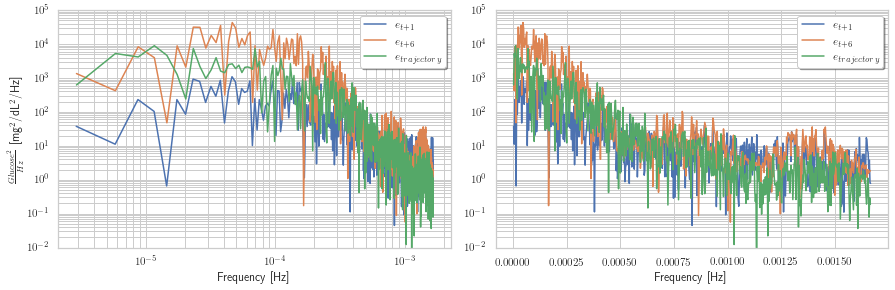

In [19]:
# Creamos la figura y el axis
fig, (ax1, ax2) = plt.subplots(1, 2)

# Realizamos el grafico
ax1.loglog(E1_N, color='C0', label=r'$e_{t+1}$')
ax1.loglog(E6_N, color='C1', label=r'$e_{t+6}$')
ax1.loglog(EE_N, color='C2', label=r'$e_{trajectory}$')

ax2.semilogy(E1_N, color='C0', label=r'$e_{t+1}$')
ax2.semilogy(E6_N, color='C1', label=r'$e_{t+6}$')
ax2.semilogy(EE_N, color='C2', label=r'$e_{trajectory}$')

# Configuramos los parametros
ax1.grid(True, which='both')
ax1.set_ylim([10 ** (-2), 10 ** 5])
ax1.legend(fancybox=True, shadow=True)

ax2.grid(True, which='both')
ax2.set_ylim([10 ** (-2), 10 ** 5])
ax2.legend(fancybox=True, shadow=True)

ax1.set_ylabel(r'$\frac{Glucose^2}{Hz}$ [mg$^2$/dL$^2$/Hz]')
ax1.set_xlabel(r'Frequency [Hz]')
ax2.set_xlabel(r'Frequency [Hz]')

x_size = 3 * 4.2
y_size = 1 * x_size / 3
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/error_periodograma_training'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

* Periodograma para el testing

In [20]:
e1 = y_test['e_1_paso'].dropna()
N = len(e1)
freq = fftfreq(N, 5*60)
E1 = fft(e1, norm='ortho')
E1_N = abs(E1) ** 2
E1_N = pd.Series(E1_N, index=freq)
E1_N = E1_N[freq > 0]

e6 = y_test['e_6_paso'].dropna()
N = len(e6)
freq = fftfreq(N, 5*60)
E6 = fft(e6, norm='ortho')
E6_N = abs(E6) ** 2
E6_N = pd.Series(E6_N, index=freq)
E6_N = E6_N[freq > 0]

ee = y_test['e_trajec'].dropna()
N = len(ee)
freq = fftfreq(N, 5*60)
EE = fft(ee, norm='ortho')
EE_N = abs(EE) ** 2
EE_N = pd.Series(EE_N, index=freq)
EE_N = EE_N[freq > 0]

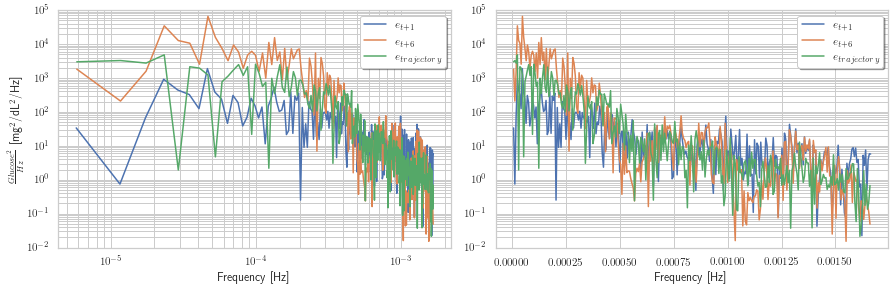

In [21]:
# Creamos la figura y el axis
fig, (ax1, ax2) = plt.subplots(1, 2)

# Realizamos el grafico
ax1.loglog(E1_N, color='C0', label=r'$e_{t+1}$')
ax1.loglog(E6_N, color='C1', label=r'$e_{t+6}$')
ax1.loglog(EE_N, color='C2', label=r'$e_{trajectory}$')

ax2.semilogy(E1_N, color='C0', label=r'$e_{t+1}$')
ax2.semilogy(E6_N, color='C1', label=r'$e_{t+6}$')
ax2.semilogy(EE_N, color='C2', label=r'$e_{trajectory}$')

# Configuramos los parametros
ax1.grid(True, which='both')
ax1.set_ylim([10 ** (-2), 10 ** 5])
ax1.legend(fancybox=True, shadow=True)

ax2.grid(True, which='both')
ax2.set_ylim([10 ** (-2), 10 ** 5])
ax2.legend(fancybox=True, shadow=True)

ax1.set_ylabel(r'$\frac{Glucose^2}{Hz}$ [mg$^2$/dL$^2$/Hz]')
ax1.set_xlabel(r'Frequency [Hz]')
ax2.set_xlabel(r'Frequency [Hz]')

x_size = 3 * 4.2
y_size = 1 * x_size / 3
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/error_periodograma_testing'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

* Espectro para el training

In [22]:
def phi_X(R_X, gamma, Ts=5 * 60):
    arg_max = R_X.argmax()
    R_X_wind = R_X[arg_max - gamma: arg_max + gamma + 1]
    wind = np.hanning(len(R_X_wind))
    phi_X = fft(R_X_wind * wind)
    freq = fftfreq(len(phi_X), Ts)
    phi_X = pd.Series(phi_X, index=freq)
    phi_X = phi_X[freq > 0]
    return phi_X

In [23]:
e1 = y_train['e_1_paso'].dropna()
e6 = y_train['e_6_paso'].dropna()
ee = y_train['e_trajec'].dropna()

R_e1 = np.correlate(e1, e1, mode='full') / N
R_e6 = np.correlate(e6, e6, mode='full') / N
R_ee = np.correlate(ee, ee, mode='full') / N

N1 = len(R_e1)
N6 = len(R_e6)
Ne = len(R_ee)

# Gamma = N/2
gamma = round(N1 / 2) - 1
phi_E1 = phi_X(R_e1, gamma)

gamma = round(N6 / 2) - 1
phi_E6 = phi_X(R_e6, gamma)

gamma = round(Ne / 2) - 1
phi_EE = phi_X(R_ee, gamma)

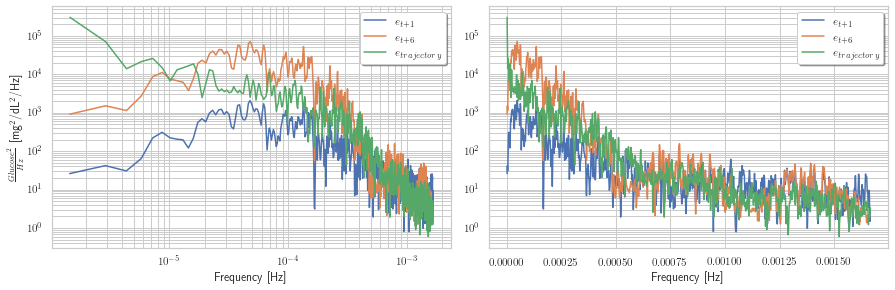

In [24]:
# Creamos la figura y el axis
fig, (ax1, ax2) = plt.subplots(1, 2)

# Realizamos el grafico
ax1.loglog(abs(phi_E1), color='C0', label=r'$e_{t+1}$')
ax1.loglog(abs(phi_E6), color='C1', label=r'$e_{t+6}$')
ax1.loglog(abs(phi_EE), color='C2', label=r'$e_{trajectory}$')

ax2.semilogy(abs(phi_E1), color='C0', label=r'$e_{t+1}$')
ax2.semilogy(abs(phi_E6), color='C1', label=r'$e_{t+6}$')
ax2.semilogy(abs(phi_EE), color='C2', label=r'$e_{trajectory}$')

# Configuramos los parametros
ax1.grid(True, which='both')
#ax1.set_ylim([10 ** (-2), 10 ** 6])
#ax1.set_xlim([10 ** (-6), max(Y_N.index)])
ax1.legend(fancybox=True, shadow=True)

ax2.grid(True, which='both')
#ax2.set_ylim([10 ** (-2), 10 ** 6])
#ax2.set_xlim([10 ** (-6), max(Y_N.index)])
ax2.legend(fancybox=True, shadow=True)

ax1.set_ylabel(r'$\frac{Glucose^2}{Hz}$ [mg$^2$/dL$^2$/Hz]')
ax1.set_xlabel(r'Frequency [Hz]')
ax2.set_xlabel(r'Frequency [Hz]')

x_size = 3 * 4.2
y_size = 1 * x_size / 3
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/error_espectro_training'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')

* Espectro para el testing

In [25]:
e1 = y_test['e_1_paso'].dropna()
e6 = y_test['e_6_paso'].dropna()
ee = y_test['e_trajec'].dropna()

R_e1 = np.correlate(e1, e1, mode='full') / N
R_e6 = np.correlate(e6, e6, mode='full') / N
R_ee = np.correlate(ee, ee, mode='full') / N

N1 = len(R_e1)
N6 = len(R_e6)
Ne = len(R_ee)

# Gamma = N/2
gamma = round(N1 / 2) - 1
phi_E1 = phi_X(R_e1, gamma)

gamma = round(N6 / 2) - 1
phi_E6 = phi_X(R_e6, gamma)

gamma = round(Ne / 2) - 1
phi_EE = phi_X(R_ee, gamma)

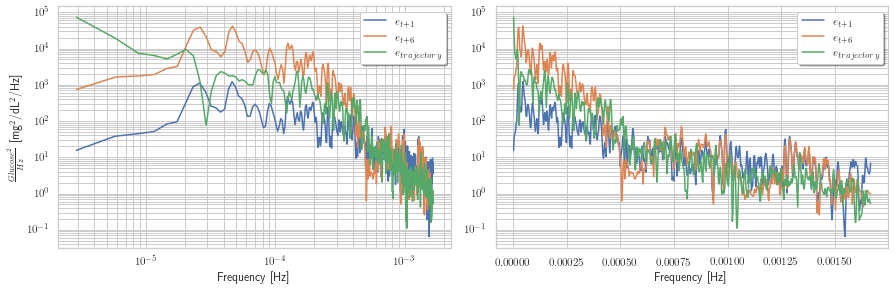

In [26]:
# Creamos la figura y el axis
fig, (ax1, ax2) = plt.subplots(1, 2)

# Realizamos el grafico
ax1.loglog(abs(phi_E1), color='C0', label=r'$e_{t+1}$')
ax1.loglog(abs(phi_E6), color='C1', label=r'$e_{t+6}$')
ax1.loglog(abs(phi_EE), color='C2', label=r'$e_{trajectory}$')

ax2.semilogy(abs(phi_E1), color='C0', label=r'$e_{t+1}$')
ax2.semilogy(abs(phi_E6), color='C1', label=r'$e_{t+6}$')
ax2.semilogy(abs(phi_EE), color='C2', label=r'$e_{trajectory}$')

# Configuramos los parametros
ax1.grid(True, which='both')
#ax1.set_ylim([10 ** (-2), 10 ** 6])
#ax1.set_xlim([10 ** (-6), max(Y_N.index)])
ax1.legend(fancybox=True, shadow=True)

ax2.grid(True, which='both')
#ax2.set_ylim([10 ** (-2), 10 ** 6])
#ax2.set_xlim([10 ** (-6), max(Y_N.index)])
ax2.legend(fancybox=True, shadow=True)

ax1.set_ylabel(r'$\frac{Glucose^2}{Hz}$ [mg$^2$/dL$^2$/Hz]')
ax1.set_xlabel(r'Frequency [Hz]')
ax2.set_xlabel(r'Frequency [Hz]')

x_size = 3 * 4.2
y_size = 1 * x_size / 3
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

format_name = 'figs/error_espectro_testing'
fig.savefig(format_name + '.svg')
fig.savefig(format_name + '.pdf')